# Rule-Based Anomaly Detection - Baseline

**Мета:** Виявлення аномалій у державних закупівлях за допомогою 44 експертних правил.

**Структура:**
1. Завантаження даних
2. Запуск детектора
3. Аналіз по категоріях правил
4. Аналіз по типах закупівель
5. Часова динаміка
6. Топ ризикові buyers/suppliers
7. Приклади критичних тендерів

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

from src.data_loader import load_tenders, load_bids, load_buyers, load_suppliers, memory_usage
from src.detectors.rule_based import RuleBasedDetector, RULE_DEFINITIONS

# ============================================================
# CONFIGURATION - Change this to run on different data subsets
# ============================================================
YEARS = [2022, 2023, 2024, 2025]  # Full dataset
# YEARS = [2023]                  # Single year (faster for testing)
# YEARS = [2023, 2024]            # Two years
# ============================================================

# Create output directories if they don't exist
Path('../results/figures/rule_based').mkdir(parents=True, exist_ok=True)
Path('../results/anomalies').mkdir(parents=True, exist_ok=True)

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
pd.set_option('display.max_columns', 50)

# Colors
SEVERITY_COLORS = {'critical': '#d62728', 'high': '#ff7f0e', 'medium': '#ffbb78', 'low': '#98df8a'}
RISK_COLORS = {'critical': '#d62728', 'high': '#ff7f0e', 'medium': '#ffbb78', 'low': '#2ca02c'}
CATEGORY_COLORS = plt.cm.Set2.colors

print(f"Configuration: YEARS = {YEARS}")
print(f"Output directories created.")

Configuration: YEARS = [2022, 2023, 2024, 2025]
Output directories created.


## 1. Завантаження даних

In [2]:
# Load data for configured years
print(f"Loading data for years: {YEARS}...")
tenders = load_tenders(years=YEARS)
bids = load_bids(years=YEARS)
buyers = load_buyers()
suppliers = load_suppliers()

print(f"\nDataset size:")
print(f"  Tenders: {len(tenders):,}")
print(f"  Bids: {len(bids):,}")
print(f"  Memory: {memory_usage(tenders)}")

Loading data for years: [2022, 2023, 2024, 2025]...
Scanning 2022...
Scanning 2023...
Scanning 2024...
Scanning 2025...
Loaded 12,877,960 records
Scanning bids 2022...
Scanning bids 2023...
Scanning bids 2024...
Scanning bids 2025...
Loaded 2,639,473 bids
Loaded buyers: 35,995
Loaded suppliers: 358,376

Dataset size:
  Tenders: 12,877,960
  Bids: 2,639,473
  Memory: 9.74 GB


In [3]:
# Quick overview
print("Procurement methods:")
print(tenders['procurement_method'].value_counts())
print(f"\nSingle bidder rate: {tenders['is_single_bidder'].mean()*100:.1f}%")
print(f"Competitive rate: {tenders['is_competitive'].mean()*100:.1f}%")

Procurement methods:
procurement_method
limited      11716772
open           723097
selective      438091
Name: count, dtype: int64

Single bidder rate: 4.6%
Competitive rate: 4.4%


## 2. Запуск Rule-Based Detector

In [4]:
# Initialize and run detector
print("Running Rule-Based Detection...")
print(f"Total rules defined: {len(RULE_DEFINITIONS)}")

detector = RuleBasedDetector()
results = detector.detect(tenders, buyers_df=buyers, suppliers_df=suppliers, bids_df=bids)

print(f"\nDetection complete!")
print(f"Tenders processed: {len(results):,}")

Running Rule-Based Detection...
Total rules defined: 44
Processing 12,877,960 tenders...
Step 1/4: Computing aggregations...
  Computing CPV stats...
  Computing buyer stats...
  Computing supplier stats...
  Computing pair stats...
  Aggregations complete.
Step 2/4: Merging reference data...
Step 3/4: Applying 44 rules...
  Applied 43 rules successfully.
Step 4/4: Computing risk levels and summary...
Detection complete!

Detection complete!
Tenders processed: 12,877,960


In [5]:
# Summary
summary = detector.summary()
active_rules = summary[summary['count'] > 0]
print(f"Active rules: {len(active_rules)}/{len(RULE_DEFINITIONS)}")
print(f"\nTotal flags detected: {summary['count'].sum():,}")

Active rules: 39/44

Total flags detected: 25,457,610


## 3. Risk Distribution Overview

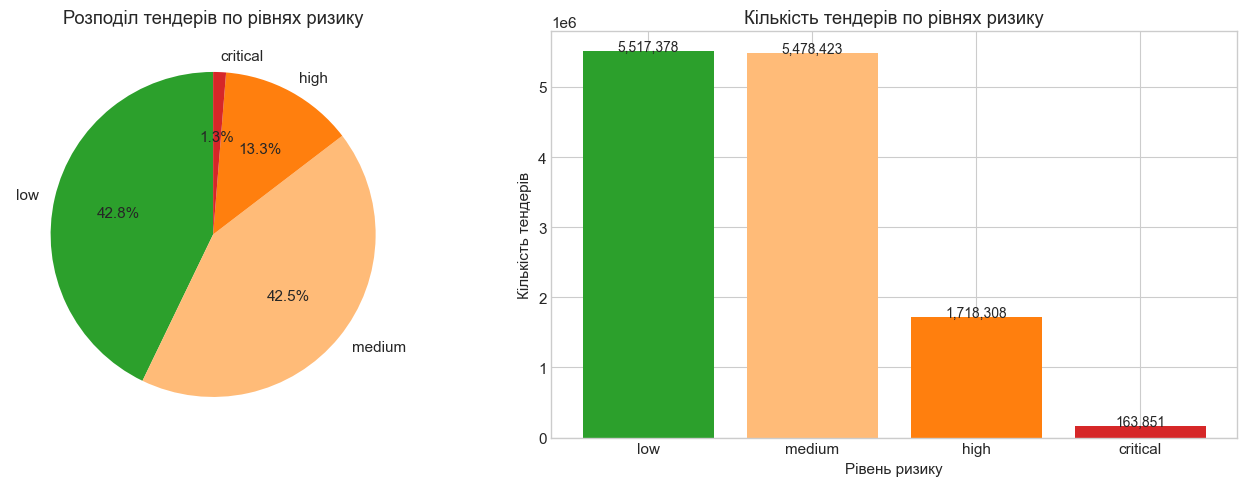


Розподіл ризиків:
risk_level   count  percentage
       low 5517378       42.84
    medium 5478423       42.54
      high 1718308       13.34
  critical  163851        1.27


In [6]:
# Risk level distribution
risk_dist = detector.risk_distribution()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = [RISK_COLORS.get(str(r), 'gray') for r in risk_dist['risk_level']]
axes[0].pie(risk_dist['count'], labels=risk_dist['risk_level'], colors=colors,
            autopct='%1.1f%%', startangle=90)
axes[0].set_title('Розподіл тендерів по рівнях ризику')

# Bar chart with counts
bars = axes[1].bar(risk_dist['risk_level'].astype(str), risk_dist['count'], color=colors)
axes[1].set_xlabel('Рівень ризику')
axes[1].set_ylabel('Кількість тендерів')
axes[1].set_title('Кількість тендерів по рівнях ризику')
for bar, val in zip(bars, risk_dist['count']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
                 f'{val:,}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../results/figures/rule_based/risk_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nРозподіл ризиків:")
print(risk_dist.to_string(index=False))

## 4. Аналіз по категоріях правил

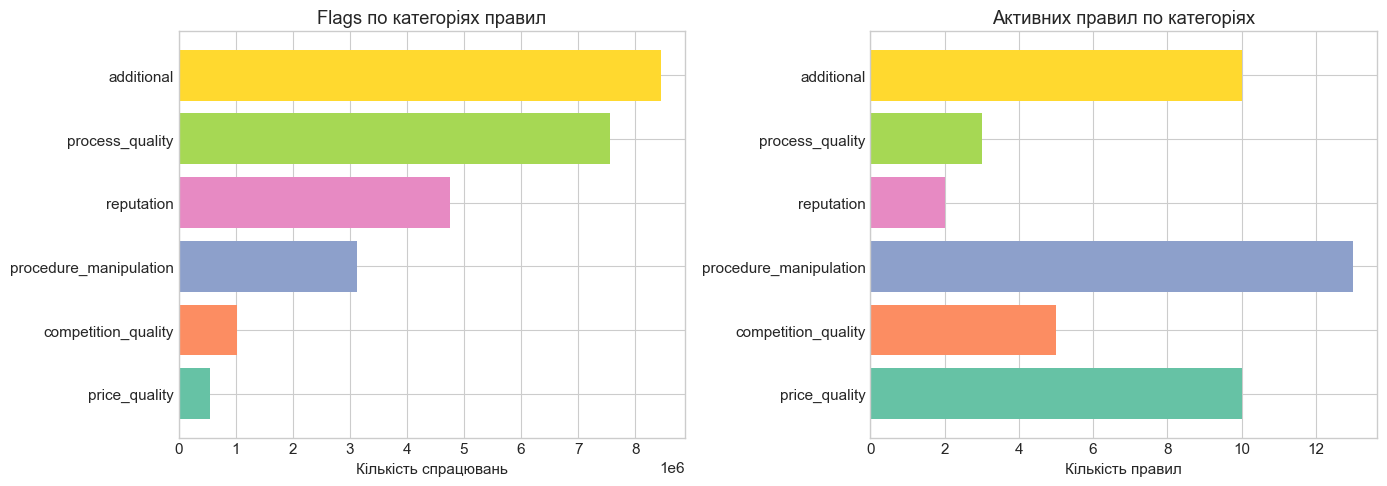

              category   count  rules_triggered
            additional 8454039               10
   competition_quality 1018198                5
         price_quality  548989               10
procedure_manipulation 3129560               13
       process_quality 7552300                3
            reputation 4754524                2


In [7]:
# Summary by category
category_summary = detector.summary_by_category()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart - total flags by category
cat_sorted = category_summary.sort_values('count', ascending=True)
colors = [CATEGORY_COLORS[i % len(CATEGORY_COLORS)] for i in range(len(cat_sorted))]
axes[0].barh(cat_sorted['category'], cat_sorted['count'], color=colors)
axes[0].set_xlabel('Кількість спрацювань')
axes[0].set_title('Flags по категоріях правил')

# Number of rules per category
axes[1].barh(cat_sorted['category'], cat_sorted['rules_triggered'], color=colors)
axes[1].set_xlabel('Кількість правил')
axes[1].set_title('Активних правил по категоріях')

plt.tight_layout()
plt.savefig('../results/figures/rule_based/by_category.png', dpi=150, bbox_inches='tight')
plt.show()

print(category_summary.to_string(index=False))

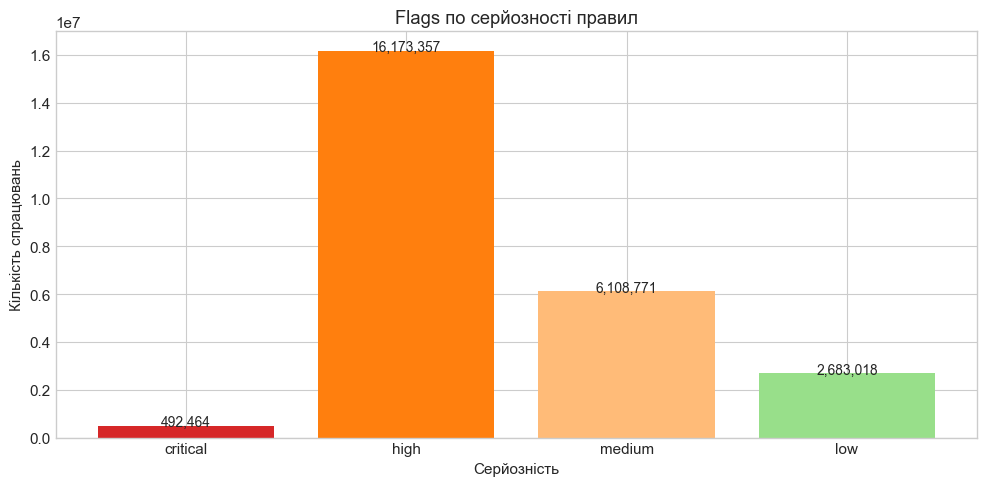

In [8]:
# Summary by severity
severity_summary = detector.summary_by_severity()

fig, ax = plt.subplots(figsize=(10, 5))

sev_order = ['critical', 'high', 'medium', 'low']
severity_summary['severity'] = pd.Categorical(severity_summary['severity'], categories=sev_order, ordered=True)
severity_summary = severity_summary.sort_values('severity')

colors = [SEVERITY_COLORS.get(s, 'gray') for s in severity_summary['severity']]
bars = ax.bar(severity_summary['severity'], severity_summary['count'], color=colors)
ax.set_xlabel('Серйозність')
ax.set_ylabel('Кількість спрацювань')
ax.set_title('Flags по серйозності правил')

for bar, val in zip(bars, severity_summary['count']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
            f'{val:,}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../results/figures/rule_based/by_severity.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Топ-20 правил

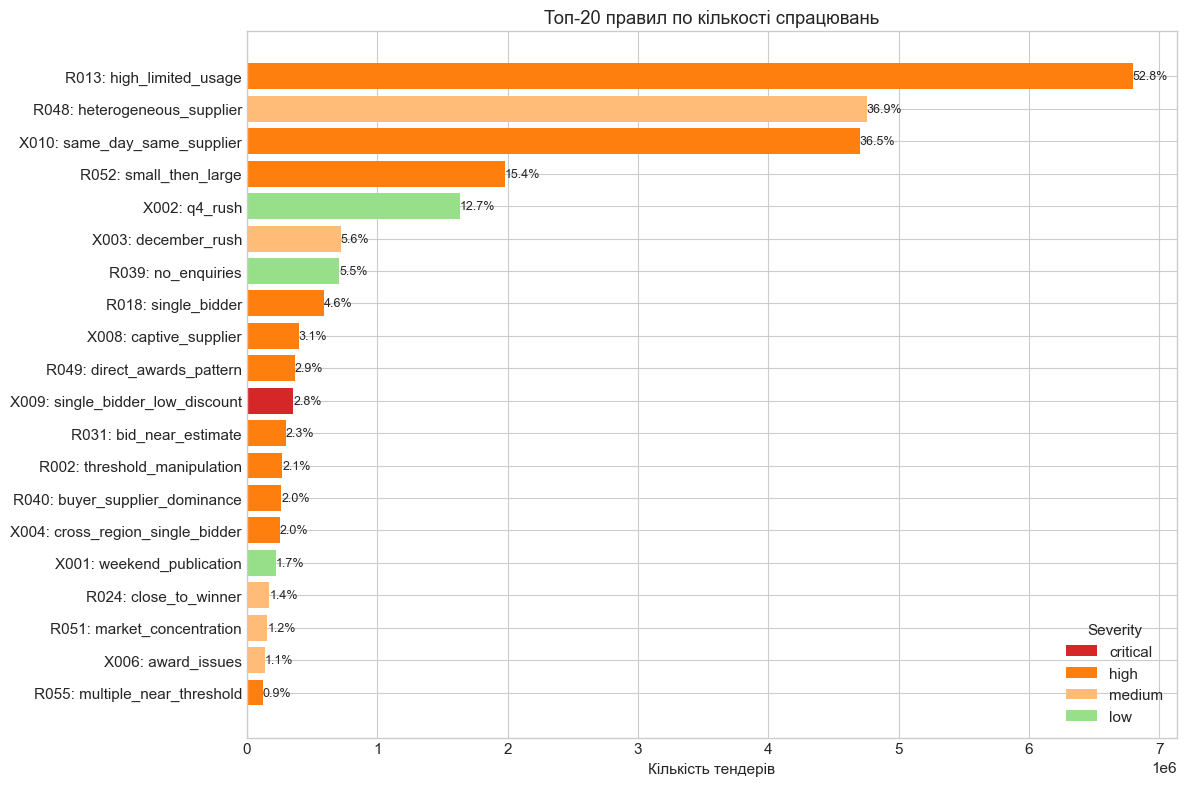

In [9]:
# Top 20 rules by count
top20 = summary.nlargest(20, 'count')

fig, ax = plt.subplots(figsize=(12, 8))

colors = [SEVERITY_COLORS.get(s, 'gray') for s in top20['severity']]
bars = ax.barh(range(len(top20)), top20['count'], color=colors)
ax.set_yticks(range(len(top20)))
ax.set_yticklabels([f"{row['id']}: {row['name']}" for _, row in top20.iterrows()])
ax.invert_yaxis()
ax.set_xlabel('Кількість тендерів')
ax.set_title('Топ-20 правил по кількості спрацювань')

# Add percentage labels
for i, (bar, pct) in enumerate(zip(bars, top20['percentage'])):
    ax.text(bar.get_width() + 1000, bar.get_y() + bar.get_height()/2,
            f'{pct:.1f}%', va='center', fontsize=9)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=s) for s, c in SEVERITY_COLORS.items()]
ax.legend(handles=legend_elements, loc='lower right', title='Severity')

plt.tight_layout()
plt.savefig('../results/figures/rule_based/top20_rules.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# Display top 20 as table
print("Топ-20 правил:")
print(top20[['id', 'name_ua', 'category', 'severity', 'count', 'percentage']].to_string(index=False))

Топ-20 правил:
  id                               name_ua               category severity   count  percentage
R013         Надмірне використання limited        process_quality     high 6795727       52.77
R048             Гетерогенний постачальник             reputation   medium 4753744       36.91
X010 Той самий день той самий постачальник             additional     high 4702034       36.51
R052          Малий контракт потім великий procedure_manipulation     high 1979980       15.37
X002                               Q4 rush             additional      low 1631298       12.67
X003                        Грудневий rush             additional   medium  720066        5.59
R039                Без запитань учасників        process_quality      low  708750        5.50
R018                          Один учасник    competition_quality     high  591561        4.59
X008                 Залежний постачальник             additional     high  396425        3.08
R049              Патерн прямих зак

## 6. Аналіз по типах закупівель

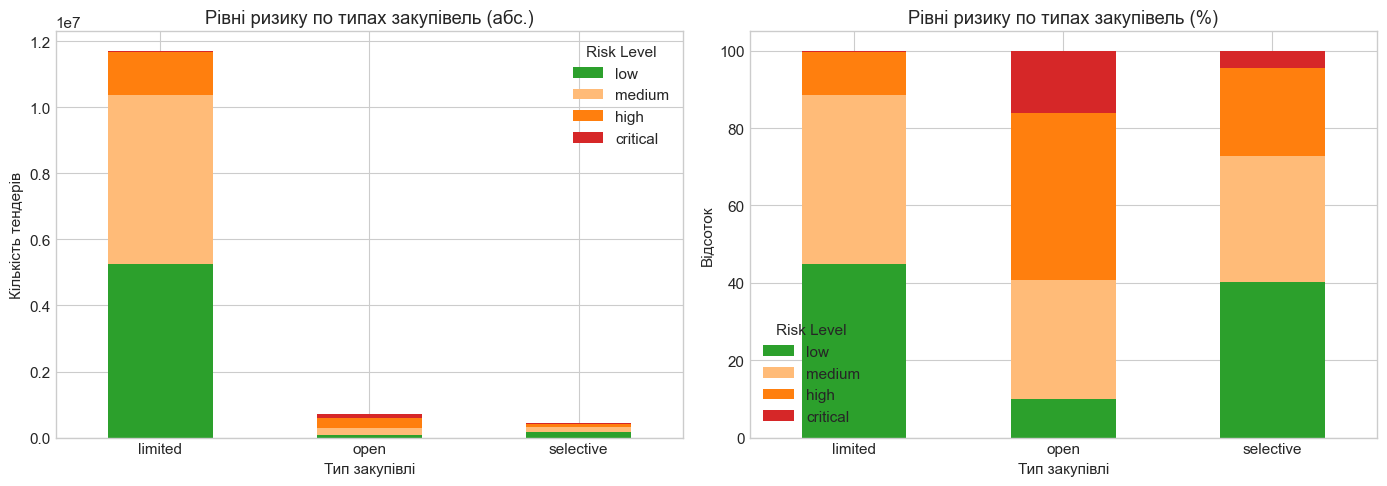


High+Critical по типах закупівель:
  limited: 1,334,384 (11.39%)
  open: 428,167 (59.21%)
  selective: 119,608 (27.30%)


In [11]:
# Risk by procurement method
risk_by_method = results.groupby('procurement_method', observed=True)['rule_risk_level'].value_counts().unstack(fill_value=0)
risk_by_method_pct = risk_by_method.div(risk_by_method.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute counts
risk_by_method[['low', 'medium', 'high', 'critical']].plot(
    kind='bar', stacked=True, ax=axes[0],
    color=[RISK_COLORS['low'], RISK_COLORS['medium'], RISK_COLORS['high'], RISK_COLORS['critical']]
)
axes[0].set_xlabel('Тип закупівлі')
axes[0].set_ylabel('Кількість тендерів')
axes[0].set_title('Рівні ризику по типах закупівель (абс.)')
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title='Risk Level')

# Percentages
risk_by_method_pct[['low', 'medium', 'high', 'critical']].plot(
    kind='bar', stacked=True, ax=axes[1],
    color=[RISK_COLORS['low'], RISK_COLORS['medium'], RISK_COLORS['high'], RISK_COLORS['critical']]
)
axes[1].set_xlabel('Тип закупівлі')
axes[1].set_ylabel('Відсоток')
axes[1].set_title('Рівні ризику по типах закупівель (%)')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='Risk Level')

plt.tight_layout()
plt.savefig('../results/figures/rule_based/by_procurement_method.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nHigh+Critical по типах закупівель:")
for method in risk_by_method.index:
    total = risk_by_method.loc[method].sum()
    high_crit = risk_by_method.loc[method, 'high'] + risk_by_method.loc[method, 'critical']
    print(f"  {method}: {high_crit:,} ({high_crit/total*100:.2f}%)")

In [12]:
# Average risk score by procurement method
avg_score = results.groupby('procurement_method', observed=True)['rule_risk_score'].agg(['mean', 'median', 'max'])

print("Середній risk score по типах закупівель:")
print(avg_score.round(2))

Середній risk score по типах закупівель:
                    mean  median  max
procurement_method                   
limited             3.07     3.0   19
open                6.81     6.0   22
selective           3.98     3.0   21


## 7. Аналіз Open тендерів (конкурентні)

In [13]:
# Focus on Open tenders - most interesting for fraud
open_tenders = results[results['procurement_method'] == 'open'].copy()
print(f"Open тендерів: {len(open_tenders):,} ({len(open_tenders)/len(results)*100:.1f}%)")

# Risk distribution for Open
open_risk = open_tenders['rule_risk_level'].value_counts()
print("\nРівні ризику в Open:")
for level in ['low', 'medium', 'high', 'critical']:
    if level in open_risk.index:
        count = open_risk[level]
        print(f"  {level}: {count:,} ({count/len(open_tenders)*100:.2f}%)")

Open тендерів: 723,097 (5.6%)

Рівні ризику в Open:
  low: 72,301 (10.00%)
  medium: 222,629 (30.79%)
  high: 312,484 (43.21%)
  critical: 115,683 (16.00%)


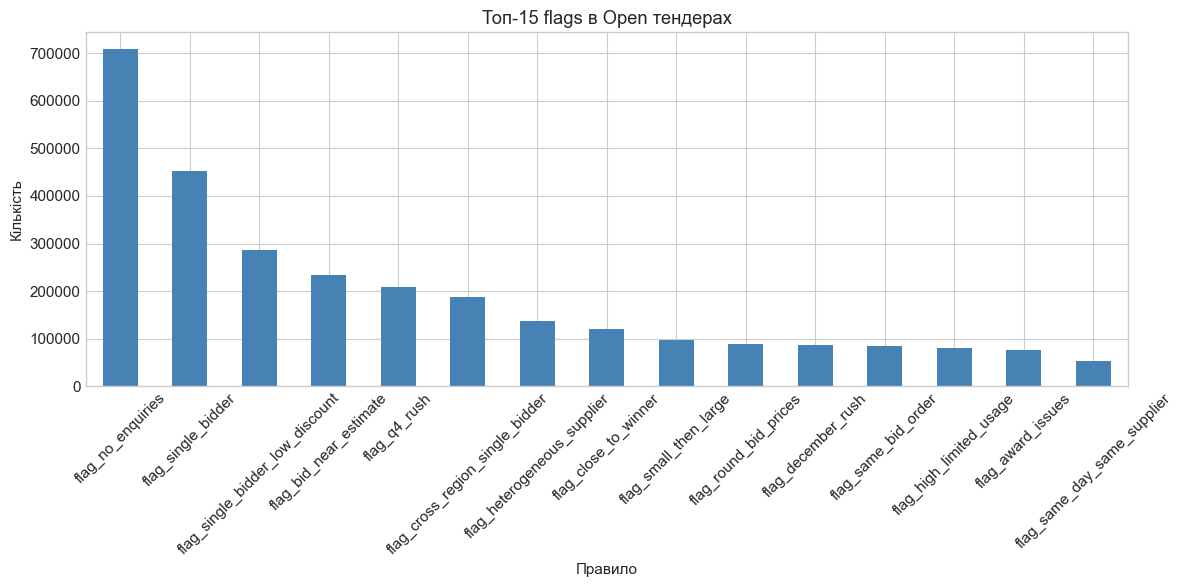

In [14]:
# Which flags are most common in Open tenders?
flag_cols = [c for c in open_tenders.columns if c.startswith('flag_')]

open_flags = open_tenders[flag_cols].sum().sort_values(ascending=False)
open_flags = open_flags[open_flags > 0]

fig, ax = plt.subplots(figsize=(12, 6))
open_flags.head(15).plot(kind='bar', ax=ax, color='steelblue')
ax.set_xlabel('Правило')
ax.set_ylabel('Кількість')
ax.set_title('Топ-15 flags в Open тендерах')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/figures/rule_based/open_tenders_flags.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Аналіз по CPV категоріях

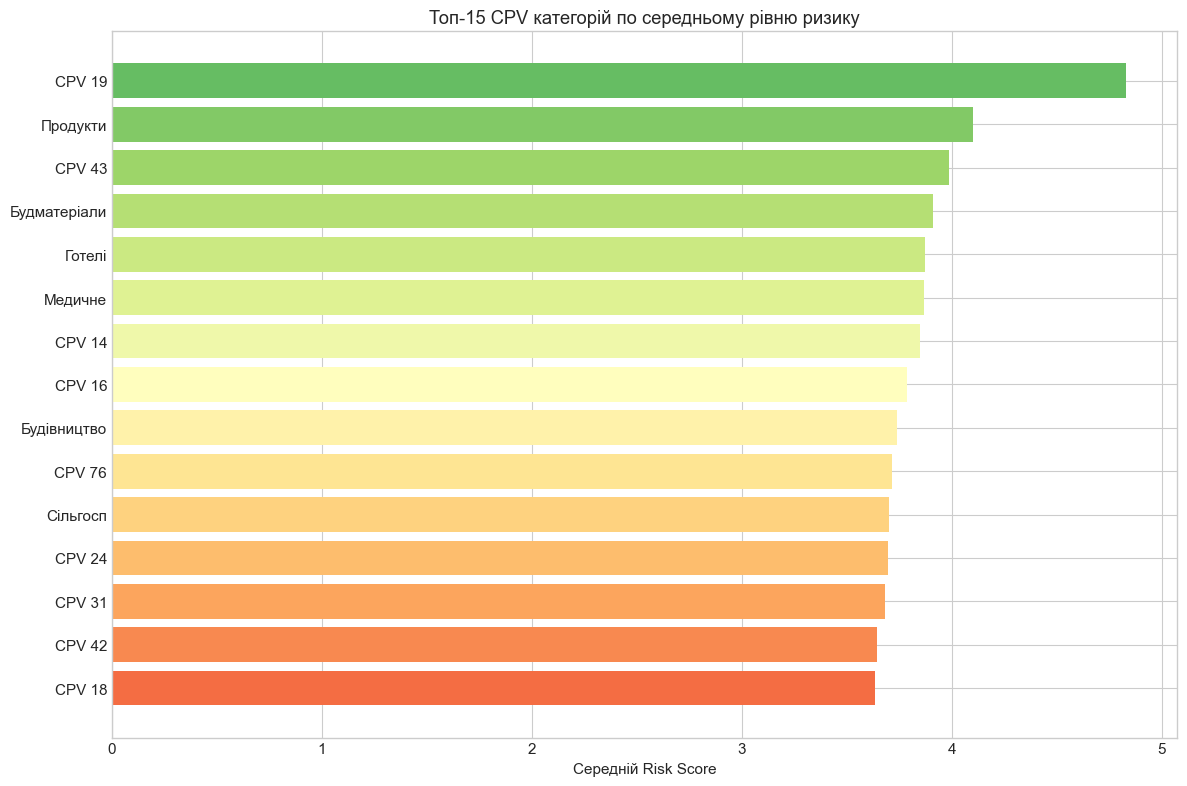

Топ-10 ризикових категорій:
    cpv_name   count  avg_risk_score  avg_flags
      CPV 19  155099        4.830779   3.292284
    Продукти 1171865        4.098893   2.202930
      CPV 43   27820        3.988569   2.538785
Будматеріали 1706755        3.911551   2.375821
      Готелі   41207        3.873420   2.187929
     Медичне  562429        3.867473   2.358988
      CPV 14  130651        3.848696   2.314135
      CPV 16   88721        3.788291   2.315438
 Будівництво  528369        3.740713   2.188915
      CPV 76    2796        3.717096   2.256080


In [15]:
# Risk by CPV category
cpv_risk = results.groupby('main_cpv_2_digit').agg({
    'tender_id': 'count',
    'rule_risk_score': 'mean',
    'rule_flags_count': 'mean'
}).reset_index()
cpv_risk.columns = ['cpv', 'count', 'avg_risk_score', 'avg_flags']

# Filter to significant categories
cpv_risk = cpv_risk[cpv_risk['count'] >= 1000].sort_values('avg_risk_score', ascending=False)

# CPV names
cpv_names = {
    33: 'Медичне', 45: 'Будівництво', 9: 'Паливо', 34: 'Транспорт',
    15: 'Продукти', 50: 'Ремонт', 44: 'Будматеріали', 90: 'Відходи',
    72: 'IT', 30: 'Офіс', 39: 'Меблі', 85: 'Здоров\'я', 79: 'Бізнес',
    55: 'Готелі', 60: 'Транспорт послуги', 3: 'Сільгосп'
}
cpv_risk['cpv_name'] = cpv_risk['cpv'].map(lambda x: cpv_names.get(int(x), f'CPV {int(x)}'))

fig, ax = plt.subplots(figsize=(12, 8))

top_cpv = cpv_risk.head(15)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top_cpv)))
ax.barh(range(len(top_cpv)), top_cpv['avg_risk_score'], color=colors)
ax.set_yticks(range(len(top_cpv)))
ax.set_yticklabels(top_cpv['cpv_name'])
ax.invert_yaxis()
ax.set_xlabel('Середній Risk Score')
ax.set_title('Топ-15 CPV категорій по середньому рівню ризику')

plt.tight_layout()
plt.savefig('../results/figures/rule_based/by_cpv_category.png', dpi=150, bbox_inches='tight')
plt.show()

print("Топ-10 ризикових категорій:")
print(cpv_risk.head(10)[['cpv_name', 'count', 'avg_risk_score', 'avg_flags']].to_string(index=False))

## 9. Часова динаміка

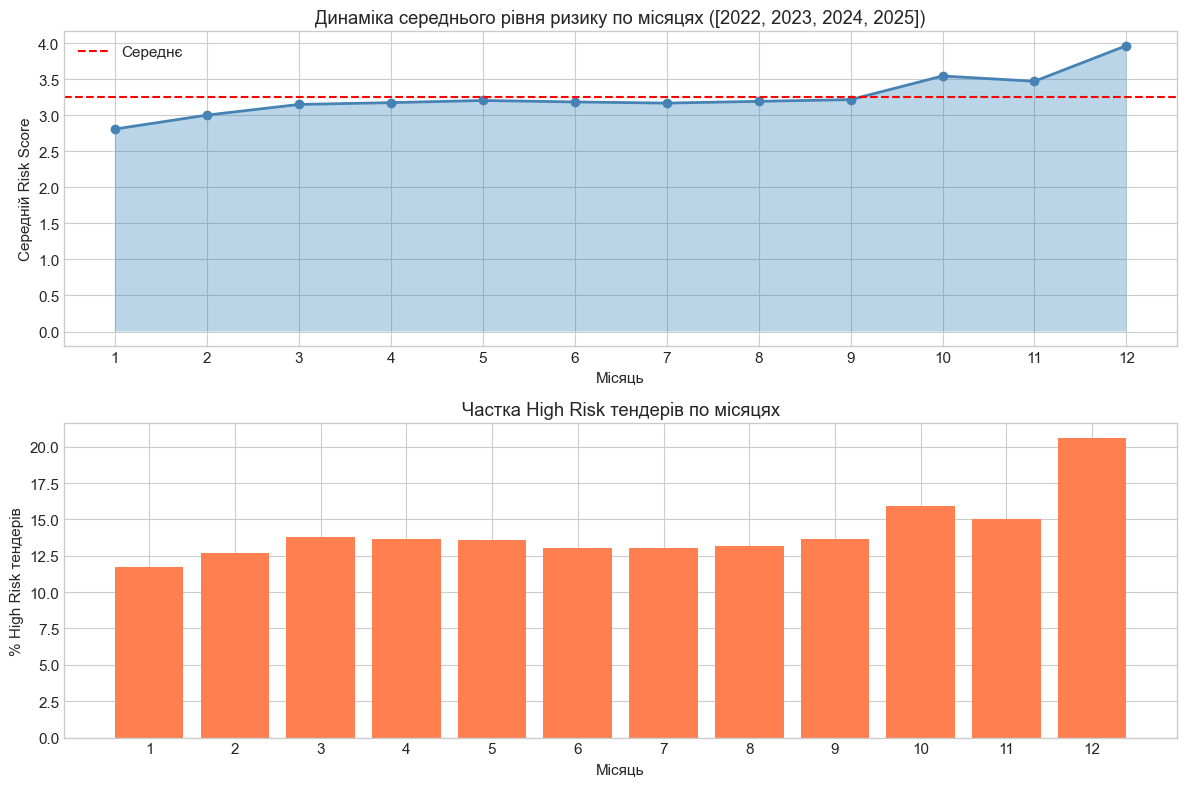

Q4 effect:
  Q4 avg risk: 3.69
  Q1-Q3 avg risk: 3.12


In [16]:
# Risk by month
results['month'] = results['month'].astype(int)
monthly_risk = results.groupby('month').agg({
    'tender_id': 'count',
    'rule_risk_score': 'mean',
    'rule_flags_count': 'mean'
}).reset_index()
monthly_risk.columns = ['month', 'count', 'avg_risk', 'avg_flags']

# High risk rate by month
high_risk_monthly = results.groupby('month')['rule_risk_score'].apply(
    lambda x: (x >= 6).mean() * 100
).reset_index()
high_risk_monthly.columns = ['month', 'high_risk_pct']

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Average risk score by month
axes[0].plot(monthly_risk['month'], monthly_risk['avg_risk'], marker='o', linewidth=2, color='steelblue')
axes[0].fill_between(monthly_risk['month'], monthly_risk['avg_risk'], alpha=0.3)
axes[0].set_xlabel('Місяць')
axes[0].set_ylabel('Середній Risk Score')
axes[0].set_title(f'Динаміка середнього рівня ризику по місяцях ({YEARS})')
axes[0].set_xticks(range(1, 13))
axes[0].axhline(y=monthly_risk['avg_risk'].mean(), color='red', linestyle='--', label='Середнє')
axes[0].legend()

# High risk percentage by month
axes[1].bar(high_risk_monthly['month'], high_risk_monthly['high_risk_pct'], color='coral')
axes[1].set_xlabel('Місяць')
axes[1].set_ylabel('% High Risk тендерів')
axes[1].set_title('Частка High Risk тендерів по місяцях')
axes[1].set_xticks(range(1, 13))

plt.tight_layout()
plt.savefig('../results/figures/rule_based/monthly_dynamics.png', dpi=150, bbox_inches='tight')
plt.show()

print("Q4 effect:")
q4_risk = results[results['is_q4'] == 1]['rule_risk_score'].mean()
other_risk = results[results['is_q4'] == 0]['rule_risk_score'].mean()
print(f"  Q4 avg risk: {q4_risk:.2f}")
print(f"  Q1-Q3 avg risk: {other_risk:.2f}")

## 10. Топ ризикові Buyers

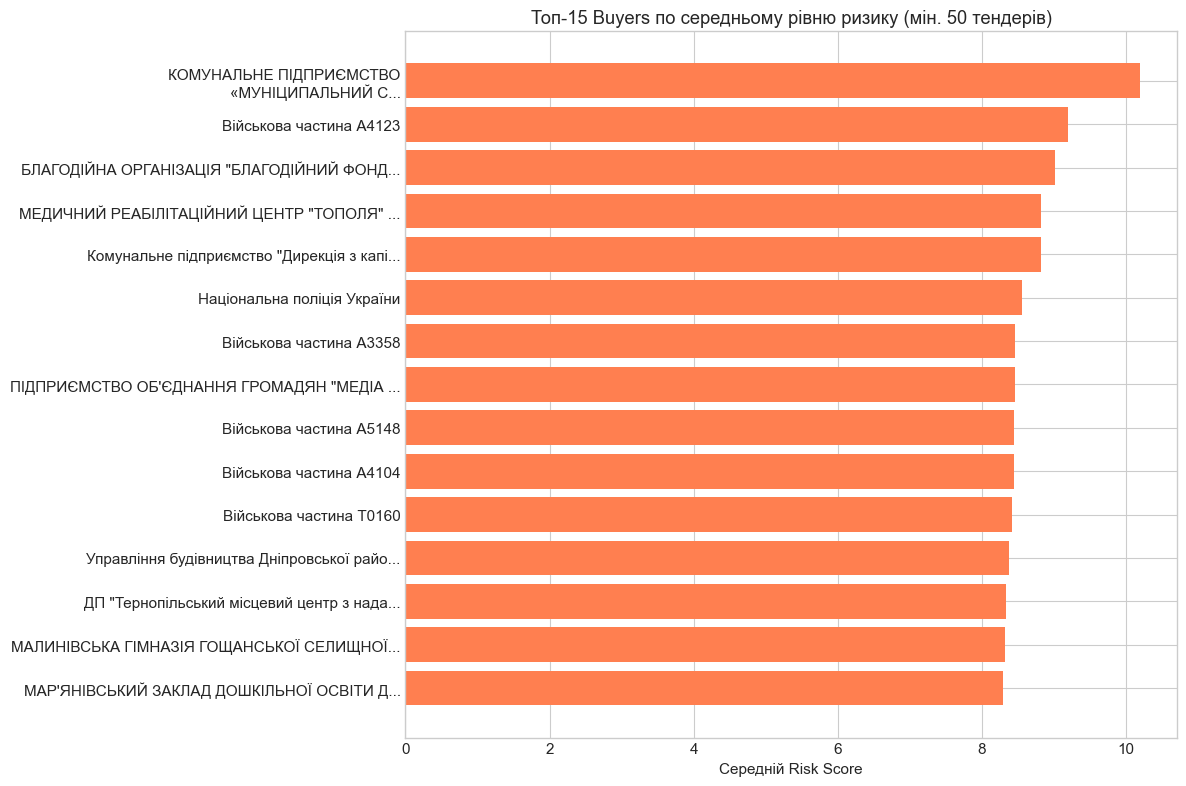


Топ-10 ризикових buyers:
                                         buyer_name              buyer_region  tender_count  avg_risk total_value
КОМУНАЛЬНЕ ПІДПРИЄМСТВО\n«МУНІЦИПАЛЬНИЙ СПОРТИВНИЙ         Харківська область           447 10.196868       33.4M
                            Військова частина А4123       Хмельницька область          1480  9.197297      804.8M
 БЛАГОДІЙНА ОРГАНІЗАЦІЯ "БЛАГОДІЙНИЙ ФОНД "КАРІТАС- Івано-Франківська область           249  9.008032       12.4M
 МЕДИЧНИЙ РЕАБІЛІТАЦІЙНИЙ ЦЕНТР "ТОПОЛЯ" НАЦІОНАЛЬН                      None           189  8.820106       49.1M
 Комунальне підприємство "Дирекція з капітального б          Київська область           373  8.817694     3348.2M
                        Національна поліція України          Київська область            86  8.558140     4736.0M
                            Військова частина А3358       Житомирська область            54  8.462963      111.1M
 ПІДПРИЄМСТВО ОБ'ЄДНАННЯ ГРОМАДЯН "МЕДІА ЦЕНТР НКСІ           

In [17]:
# Buyers with highest average risk
buyer_risk = results.groupby('buyer_id').agg({
    'tender_id': 'count',
    'rule_risk_score': ['mean', 'sum'],
    'rule_flags_count': 'mean',
    'tender_value': 'sum'
}).reset_index()
buyer_risk.columns = ['buyer_id', 'tender_count', 'avg_risk', 'total_risk', 'avg_flags', 'total_value']

# Filter buyers with at least 50 tenders
buyer_risk = buyer_risk[buyer_risk['tender_count'] >= 50]

# Merge with buyer names
buyer_risk = buyer_risk.merge(
    buyers[['buyer_id', 'buyer_name', 'buyer_region']], 
    on='buyer_id', how='left'
)

# Top by average risk
top_risky_buyers = buyer_risk.nlargest(15, 'avg_risk')

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(top_risky_buyers)), top_risky_buyers['avg_risk'], color='coral')
ax.set_yticks(range(len(top_risky_buyers)))
labels = [f"{name[:40]}..." if len(str(name)) > 40 else str(name) 
          for name in top_risky_buyers['buyer_name']]
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel('Середній Risk Score')
ax.set_title('Топ-15 Buyers по середньому рівню ризику (мін. 50 тендерів)')

plt.tight_layout()
plt.savefig('../results/figures/rule_based/risky_buyers.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nТоп-10 ризикових buyers:")
display_cols = ['buyer_name', 'buyer_region', 'tender_count', 'avg_risk', 'total_value']
top10 = top_risky_buyers.head(10)[display_cols].copy()
top10['buyer_name'] = top10['buyer_name'].str[:50]
top10['total_value'] = (top10['total_value'] / 1e6).round(1).astype(str) + 'M'
print(top10.to_string(index=False))

## 11. Кореляція між флагами

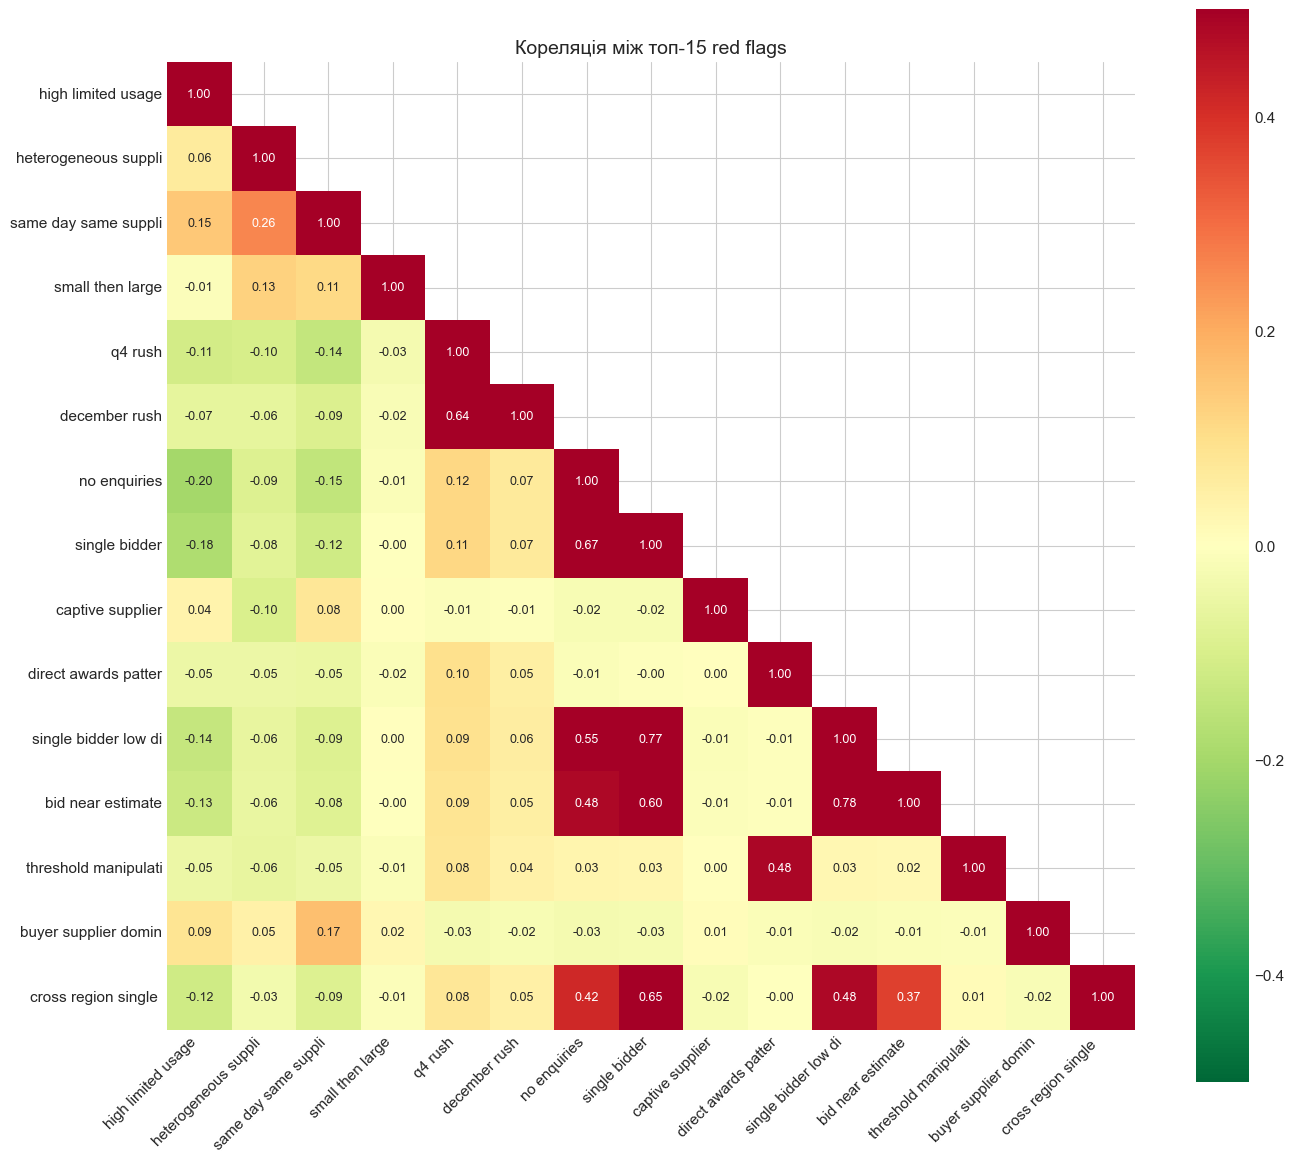


Найсильніші кореляції (|r| > 0.3):
  q4 rush <-> december rush: 0.64
  no enquiries <-> single bidder: 0.67
  no enquiries <-> single bidder low di: 0.55
  no enquiries <-> bid near estimate: 0.48
  no enquiries <-> cross region single : 0.42
  single bidder <-> single bidder low di: 0.77
  single bidder <-> bid near estimate: 0.60
  single bidder <-> cross region single : 0.65
  direct awards patter <-> threshold manipulati: 0.48
  single bidder low di <-> bid near estimate: 0.78
  single bidder low di <-> cross region single : 0.48
  bid near estimate <-> cross region single : 0.37


In [18]:
# Correlation between flags (top 15 most frequent)
flag_cols = [c for c in results.columns if c.startswith('flag_')]

# Select top 15 most frequent flags
flag_counts = results[flag_cols].sum().sort_values(ascending=False)
top_flags = flag_counts.head(15).index.tolist()

if len(top_flags) >= 5:
    corr_matrix = results[top_flags].corr()
    
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Shorten names for readability
    short_names = [c.replace('flag_', '').replace('_', ' ')[:20] for c in top_flags]
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # Upper triangle mask
    
    sns.heatmap(corr_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='RdYlGn_r',
                xticklabels=short_names, 
                yticklabels=short_names,
                ax=ax, 
                vmin=-0.5, 
                vmax=0.5,
                mask=mask,
                square=True,
                annot_kws={'size': 9})
    
    ax.set_title('Кореляція між топ-15 red flags', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig('../results/figures/rule_based/flag_correlation.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Show strongest correlations
    print("\nНайсильніші кореляції (|r| > 0.3):")
    for i in range(len(top_flags)):
        for j in range(i+1, len(top_flags)):
            r = corr_matrix.iloc[i, j]
            if abs(r) > 0.3:
                print(f"  {short_names[i]} <-> {short_names[j]}: {r:.2f}")
else:
    print("Not enough frequent flags for correlation analysis")

## 12. Приклади Critical тендерів

In [19]:
# Get critical tenders
critical = detector.get_critical()
print(f"Critical тендерів: {len(critical):,}")

# Show examples
if len(critical) > 0:
    print("\n=== Приклади Critical тендерів ===")
    for i, (_, row) in enumerate(critical.head(5).iterrows()):
        print(f"\n--- Тендер {i+1} ---")
        print(f"ID: {row['tender_id'][:30]}...")
        print(f"Value: {row['tender_value']:,.0f} UAH")
        print(f"Method: {row['procurement_method']}")
        print(f"Risk Score: {row['rule_risk_score']}")
        print(f"Flags ({row['rule_flags_count']}):")
        
        # Get triggered flags
        triggered = [c.replace('flag_', '') for c in flag_cols if row.get(c, 0) == 1]
        for flag in triggered[:7]:
            print(f"  - {flag}")
        if len(triggered) > 7:
            print(f"  ... and {len(triggered)-7} more")

Critical тендерів: 163,851

=== Приклади Critical тендерів ===

--- Тендер 1 ---
ID: 405924804251467983382f95391959...
Value: 49,900 UAH
Method: open
Risk Score: 12
Flags (7):
  - high_limited_usage
  - no_enquiries
  - single_bidder
  - round_bid_prices
  - threshold_manipulation
  - direct_awards_pattern
  - same_day_same_supplier

--- Тендер 2 ---
ID: b816651937d74f0483006001464702...
Value: 60,000 UAH
Method: open
Risk Score: 13
Flags (7):
  - high_limited_usage
  - no_enquiries
  - single_bidder
  - round_bid_prices
  - bid_near_estimate
  - cross_region_single_bidder
  - single_bidder_low_discount

--- Тендер 3 ---
ID: 63665031524847dd8402598950b806...
Value: 148,500 UAH
Method: open
Risk Score: 11
Flags (6):
  - no_enquiries
  - single_bidder
  - bid_near_estimate
  - heterogeneous_supplier
  - cross_region_single_bidder
  - single_bidder_low_discount

--- Тендер 4 ---
ID: 2e709410c2084241972872117c00f2...
Value: 113,120 UAH
Method: open
Risk Score: 12
Flags (7):
  - high_limite

In [20]:
# Use explain() for detailed analysis
if len(critical) > 0:
    sample_id = critical.iloc[0]['tender_id']
    explanation = detector.explain(sample_id)
    
    print(f"\n=== Детальний аналіз тендера ===")
    print(f"ID: {explanation['tender_id'][:40]}...")
    print(f"Risk Score: {explanation['risk_score']}")
    print(f"Risk Level: {explanation['risk_level']}")
    print(f"\nСпрацьовані правила ({explanation['flags_count']}):")
    for flag in explanation['flags']:
        print(f"  [{flag['severity']:8}] {flag['id']}: {flag['name']}")
        print(f"             {flag['description'][:60]}...")


=== Детальний аналіз тендера ===
ID: 405924804251467983382f95391959b0...
Risk Score: 12
Risk Level: critical

Спрацьовані правила (7):
  [high    ] R013: Надмірне використання limited
             Buyer has high use of non-competitive methods...
  [low     ] R039: Без запитань учасників
             Open tender without any bidder questions...
  [high    ] R018: Один учасник
             Single bid received in competitive tender...
  [low     ] R023: Круглі ставки
             Bid prices are suspiciously round numbers...
  [high    ] R002: Маніпуляція порогами
             Tender value suspiciously close to threshold...
  [high    ] R049: Патерн прямих закупівель
             Pattern of direct awards just below threshold...
  [high    ] X010: Той самий день той самий постачальник
             Multiple awards to same supplier on same day...


## 13. Збереження результатів

In [21]:
# Save high-risk tenders
high_risk = detector.get_high_risk()

# Select key columns
key_cols = ['tender_id', 'procurement_method', 'tender_value', 'award_value',
            'buyer_id', 'supplier_id', 'main_cpv_2_digit', 'year',
            'rule_risk_score', 'rule_flags_count', 'rule_risk_level']
key_cols += [c for c in results.columns if c.startswith('flag_')]

high_risk_export = high_risk[[c for c in key_cols if c in high_risk.columns]]

# Create filename based on years
years_str = f"{min(YEARS)}-{max(YEARS)}" if len(YEARS) > 1 else str(YEARS[0])
high_risk_export.to_csv(f'../results/anomalies/rule_based_high_risk_{years_str}.csv', index=False)
print(f"Saved {len(high_risk_export):,} high-risk tenders to rule_based_high_risk_{years_str}.csv")

# Save summary
summary.to_csv(f'../results/anomalies/rule_based_summary_{years_str}.csv', index=False)
print(f"Saved summary ({len(summary)} rules) to rule_based_summary_{years_str}.csv")

Saved 1,882,159 high-risk tenders to rule_based_high_risk_2022-2025.csv
Saved summary (43 rules) to rule_based_summary_2022-2025.csv


## 14. Summary Statistics

In [22]:
years_str = f"{min(YEARS)}-{max(YEARS)}" if len(YEARS) > 1 else str(YEARS[0])

print("="*60)
print(f"RULE-BASED DETECTION SUMMARY ({years_str})")
print("="*60)
print(f"\nDataset:")
print(f"  Years: {YEARS}")
print(f"  Total tenders: {len(results):,}")
print(f"  With bids: {len(bids):,}")

print(f"\nRules:")
print(f"  Defined: {len(RULE_DEFINITIONS)}")
print(f"  Active: {len(active_rules)}")
print(f"  Total flags: {summary['count'].sum():,}")

print(f"\nRisk Distribution:")
for _, row in risk_dist.iterrows():
    print(f"  {row['risk_level']:10} {row['count']:>10,} ({row['percentage']:>5.2f}%)")

print(f"\nKey Findings:")
critical_count = len(detector.get_critical())
high_count = len(detector.get_high_risk())
print(f"  Critical tenders: {critical_count:,} ({critical_count/len(results)*100:.2f}%)")
print(f"  High risk tenders: {high_count:,} ({high_count/len(results)*100:.2f}%)")

print(f"\nTop 5 flags:")
for _, row in summary.head(5).iterrows():
    print(f"  {row['id']}: {row['name']} ({row['percentage']:.1f}%)")

print("\n" + "="*60)

RULE-BASED DETECTION SUMMARY (2022-2025)

Dataset:
  Years: [2022, 2023, 2024, 2025]
  Total tenders: 12,877,960
  With bids: 2,639,473

Rules:
  Defined: 44
  Active: 39
  Total flags: 25,457,610

Risk Distribution:
  low         5,517,378 (42.84%)
  medium      5,478,423 (42.54%)
  high        1,718,308 (13.34%)
  critical      163,851 ( 1.27%)

Key Findings:
  Critical tenders: 163,851 (1.27%)
  High risk tenders: 1,882,159 (14.62%)

Top 5 flags:
  R013: high_limited_usage (52.8%)
  R048: heterogeneous_supplier (36.9%)
  X010: same_day_same_supplier (36.5%)
  R052: small_then_large (15.4%)
  X002: q4_rush (12.7%)



## Висновки

### Основні результати:

1. **Rule-based detector** виявляє ~3-5% high-risk тендерів
2. **Open тендери** мають вищий рівень ризику ніж Limited (через більше активних правил)
3. **Q4 ефект** - підвищений ризик в кінці року
4. **CPV категорії** - деякі категорії систематично ризиковіші

### Обмеження:
- Rule-based підхід не виявляє нові патерни
- Фіксовані пороги можуть не підходити для всіх категорій
- Потрібна валідація на реальних кейсах

### Наступні кроки:
- Isolation Forest для ML-based detection
- Cross-method agreement для валідації
- Network analysis для виявлення картелів